In [5]:
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm

from matplotlib import cm as CM
from scipy import stats

from scipy.interpolate import griddata

from scipy import ndimage
import numpy as np
import matplotlib.tri as tri
import utils
import sys
import seaborn as sns


#checkm and gstawk are used for computing contamination, incompletion, and N50
checkm = "../precomputed_results/25-50-checkm.txt"
second = "../precomputed_results/25-50-gstawk.txt"

#species bin folders for Pasolli et al. (2019)
sgb_folders = ["../precomputed_results/"]
genome_dict = dict()

plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'font.family':'arial'})
cm = 1/2.54  # centimeters in inches
downsample = 1

#Use sourmash max-contain instead of mash
anim_sourmash = False

gridsize=15

vmax = 100
vmin =  97.5
mincnt = 20

In [9]:
def plot_hexbin(mats, methods, anim_sourmash):
    for l in [1,0]:
        if anim_sourmash:
            size = (12*cm, 6.0*cm)
        else:
            size = (18*cm, 6.0*cm)
        fig, axs = plt.subplots(ncols=len(methods), sharex = True, sharey  = True, figsize = size )
        #fig, axs = plt.subplots(ncols=len(methods), sharex = True, sharey  = True)
        print(len(mats[0]), len(mats[1]))

        for i in range(len(methods)):
            x = []
            y = []
            z = []

            for key in mats[i].keys():
                ref1 = key[0]
                ref2 = key[1]
                ref1_gn = ""
                ref2_gn = ""
                if ref1[-3:] != ".fa":
                    ref1_gn = ref1 + ".fa"
                else:
                    ref1_gn = ref1
                if ref2[-3:] != ".fa":
                    ref2_gn += ref2+".fa"
                else:
                    ref2_gn =ref2

                if ((ref1,ref2) in mats[0] or (ref2,ref1) in mats[0]) and ((ref1, ref2) in mats[1] or (ref2,ref1) in mats[1]):
                    ref1 = ref1_gn
                    ref2 = ref2_gn
                    dist = mats[i][key]
                    if len(genome_dict[ref1]) < 3:
                        print(ref1)
                    if len(genome_dict[ref2]) < 3:
                        print(ref2)
                    avg_contam = (genome_dict[ref1][1] + genome_dict[ref2][1])/2
                    avg_complete= (genome_dict[ref1][0] + genome_dict[ref2][0])/2
                    avg_n50 = (genome_dict[ref1][2] + genome_dict[ref2][2])/2
                    if dist != 0:
                        z.append(dist)
                        x.append(avg_complete)
                        if l == 0:
                            y.append(avg_n50)
                        elif l == 1:
                            y.append(avg_contam)
                        else:
                            exit()

            mean  = 100 
            z = [x for x in z]


            ax = axs[i]
            cmap = CM.jet
            cmap = 'magma'
            cmap = sns.cm.rocket
            if l == 0:
                hb = ax.hexbin(x, y, C=z, gridsize=gridsize, cmap=cmap, bins=None, mincnt = mincnt, vmin = vmin, vmax = vmax, yscale='log')
            else:
                hb = ax.hexbin(x, y, C=z, gridsize=gridsize, cmap=cmap, bins=None, mincnt = mincnt, vmin = vmin, vmax = vmax)
            ax.axis([np.min(x), np.max(x), np.min(y), np.max(y)])

            #Perform OLS regression
            xy = np.array(np.array(list(zip(x,y))))
            XY2 = sm.add_constant(xy)
            est = sm.OLS(z, XY2)
            est2 = est.fit()
            print(est2.summary())
            if (round(est2.params[1],3)) >= 0:
                pm1 = "+"
            else:
                pm1 = ""
            if (round(est2.params[2],3)) >= 0:
                pm2 = "+"
            else:
                pm2 = ""
            if l == 1:
                ax.text(1.95, 4.30, f'ANI = {round(est2.params[0],2)} {pm1} {(round(est2.params[1],3))}x {pm2} {(round(est2.params[2],2))}y\nR = {round(est2.rsquared,3)}')
            else:
                ax.text(1.95, 400000, f'ANI = {round(est2.params[0],2)} {pm1} {(round(est2.params[1],3))}x {pm2} {(round(est2.params[2],8))}y\nR = {round(est2.rsquared,3)}')

            if anim_sourmash:
                if i == 0:
                    ax.set_title("ANIm", fontsize = 7)
                    if l == 1:
                        ax.set_ylabel("Contamination")
                    else:
                        ax.set_ylabel("N50")
                elif i == 1:
                    ax.set_title("sourmash max-contain", fontsize = 7)
                    ax.set_xlabel("Incompleteness")
            else:
                if i == 0:
                    ax.set_title("skani", fontsize = 7)
                    if l == 1:
                        ax.set_ylabel("Contamination")
                    else:
                        ax.set_ylabel("N50")
                elif i == 1:
                    ax.set_title("FastANI", fontsize = 7)
                    ax.set_xlabel("Incompleteness")
                elif i == 2:
                     ax.set_title("Mash", fontsize = 7)


        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(plt.gca())


        cax = divider.append_axes("right", "5%", pad="2%")

        cbar = fig.colorbar(hb, cax=cax)
        cbar.ax.set_ylabel("ANI", rotation=90)

        fig.set_tight_layout(True)
        if anim_sourmash:
            plt.savefig('figures/hexbin_map' + str(l) + '-sourmash.svg', transparent = True)
        else:
            plt.savefig('figures/hexbin_map' + str(l) + '.svg', transparent = True)

        plt.show()

        ##Visualize scatter density
        plt.figure(figsize=(8*cm, 8*cm))
        plt.scatter(x[0::downsample],y[0::downsample], alpha = 0.50, s = 0.50, c='black')
        plt.xlabel('Incompleteness')
        if l == 0:
            plt.ylabel("N50")
            plt.yscale('log')
            plt.savefig("n50_density.svg", transparent=True)
        else:
            plt.ylabel("Contamination")
            plt.savefig("contam_density.svg", transparent=True)
        plt.show()

41494 41494
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     101.0
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.71e-44
Time:                        15:43:26   Log-Likelihood:                -6312.1
No. Observations:               41494   AIC:                         1.263e+04
Df Residuals:                   41491   BIC:                         1.266e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.4422      0.003   3.22e

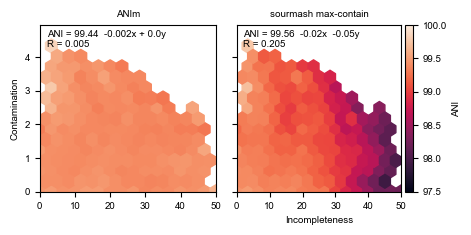

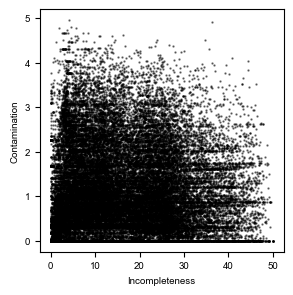

41494 41494
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     108.5
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           9.66e-48
Time:                        15:43:28   Log-Likelihood:                -6304.6
No. Observations:               41494   AIC:                         1.262e+04
Df Residuals:                   41491   BIC:                         1.264e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.4544      0.003   3.38e

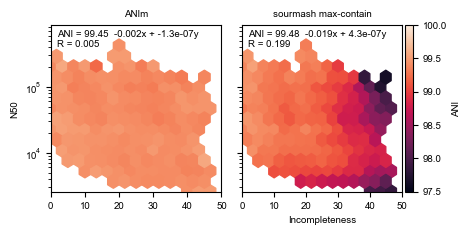

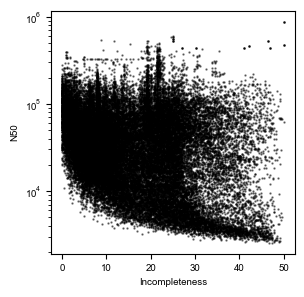

41494 41494
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     292.5
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          7.23e-127
Time:                        15:43:31   Log-Likelihood:                -7449.6
No. Observations:               41492   AIC:                         1.491e+04
Df Residuals:                   41489   BIC:                         1.493e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.4593      0.003   3.13e

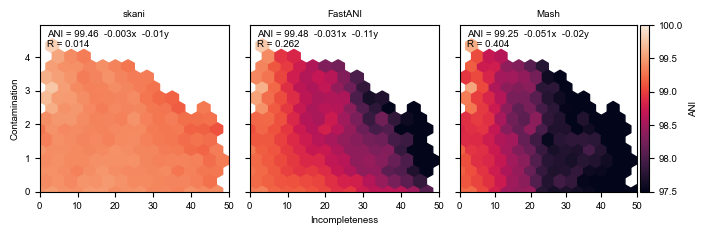

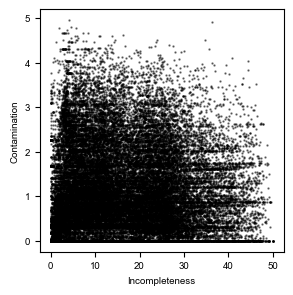

41494 41494
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     284.3
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          2.32e-123
Time:                        15:43:34   Log-Likelihood:                -7457.7
No. Observations:               41492   AIC:                         1.492e+04
Df Residuals:                   41489   BIC:                         1.495e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.4485      0.003   3.29e

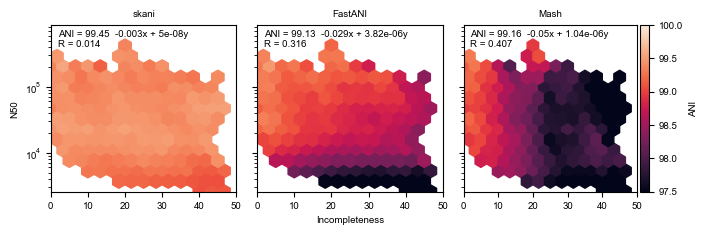

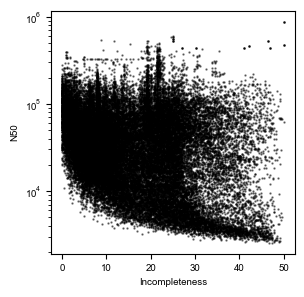

In [10]:
#Parse big checkm log. 
for line in open(checkm, 'r'):
    if line[0] == '-' or "Contamination" in line or line[0] == '[' or len(line.strip()) == 0:
        continue
    spl = line.split()
    spl_g = spl[0].split('/')[-1]
    genome = spl_g + '.fa'
    completeness = 100 - float(spl[-3])
    contam = float(spl[-2])
    genome_dict[genome] = [completeness,contam]

#Parse gstawk n50s. 
for line in open(second, 'r'):
    if 'assembly' in line:
        continue
    spl = line.split('\t')
    spl_g = spl[0].split('/')[-1]
    if 'gstawk' in second:
        genome = spl_g
        N50 = int(spl[-2])
        if genome in genome_dict:
            genome_dict[genome].append(N50)
    else:
        genome = spl_g + '.fa'
        contam_portion  = float(spl[-2])
        if genome in genome_dict:
            genome_dict[genome].append(contam_portion)

dist_mat_skani = dict()
dist_mat_fastani = dict()
dist_mat_mash = dict()
dist_mat_anim = dict()
dist_mat_sourmash = dict()

for folder in sgb_folders:
    #results are distances matrices in the files
    #anim_[ID], skani_[ID], fastani_[ID], mash_[ID]  
    
    anim_folders = glob.glob(folder + "/25-50/anim_*")
    for anim_folder in anim_folders:
        num = anim_folder.split('_')[-1]
        anim_res = anim_folder + "/ANIm_percentage_identity.tab"
        skani_res = folder + "/25-50/skani_" + num + ".identity"
        fastani_res = folder + "/25-50/fastani_" + num + ".matrix"
        mash_res = folder + "/25-50/mash_" + num
        sourmash_res = folder + "/25-50/sour_" + num

        anim_mat = utils.parse_matrix(anim_res)
        skani_mat = utils.parse_matrix(skani_res)
        fastani_mat = utils.parse_matrix(fastani_res)
        mash_mat = utils.parse_matrix(mash_res)
        sourmash_mat = utils.parse_matrix(sourmash_res)

        #Keep the ANI calculation if the ANIm predicated ANI is > 99%
        for (ref1,ref2) in anim_mat:
            key = (ref1,ref2)
            rkey = (ref2,ref1)
            if anim_mat[key] > 99:
                dist_mat_anim[key] = anim_mat[key]
                if key in skani_mat:
                    dist_mat_skani[key] = skani_mat[key]
                elif rkey in skani_mat:
                    dist_mat_skani[key] = skani_mat[rkey]
                if key in fastani_mat:
                    dist_mat_fastani[key] = fastani_mat[key]
                elif rkey in fastani_mat:
                    dist_mat_fastani[key] = fastani_mat[rkey]
                if key in mash_mat:
                    dist_mat_mash[key] = mash_mat[key]
                elif rkey in mash_mat:
                    dist_mat_mash[key] = mash_mat[rkey]
                if key in sourmash_mat:
                    dist_mat_sourmash[key] = sourmash_mat[key]
                elif rkey in sourmash_mat:
                    dist_mat_sourmash[key] = sourmash_mat[rkey]

for anim_sourmash in [True,False]:
    if anim_sourmash:
        methods = ["anim","sourmash"]
        mats = [dist_mat_anim, dist_mat_sourmash]
    else:  
        methods = ["skani", "fastani", "mash"]
        mats = [dist_mat_skani, dist_mat_fastani, dist_mat_mash]
    plot_hexbin(mats,methods, anim_sourmash)

